In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

/tmp/ipykernel_2547976/3445827236.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                                             | 0/60000 [00:00<?, ?it/s]

 12%|█████████████▋                                                                                                 | 7393/60000 [00:00<00:00, 73923.90it/s]

 25%|███████████████████████████▎                                                                                  | 14902/60000 [00:00<00:00, 74606.93it/s]

 37%|████████████████████████████████████████▉                                                                     | 22363/60000 [00:00<00:00, 73496.23it/s]

 50%|██████████████████████████████████████████████████████▋                                                       | 29816/60000 [00:00<00:00, 73895.77it/s]

 62%|████████████████████████████████████████████████████████████████████▎                                         | 37258/60000 [00:00<00:00, 74081.83it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                            | 44668/60000 [00:00<00:00, 73123.69it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▍              | 52055/60000 [00:00<00:00, 73362.26it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 59604/60000 [00:00<00:00, 74031.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 73624.26it/s]

  0%|                                                                                                                             | 0/10000 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 7526/10000 [00:00<00:00, 75254.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 74750.65it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 56bs93uv


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    fpi = 10

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                               | 0/375 [00:00<?, ?it/s]

  0%|▎                                                                                                                      | 1/375 [00:00<03:05,  2.01it/s]

  1%|█▌                                                                                                                     | 5/375 [00:00<00:37,  9.95it/s]

  2%|██▊                                                                                                                    | 9/375 [00:00<00:22, 16.59it/s]

  3%|████                                                                                                                  | 13/375 [00:00<00:16, 21.85it/s]

  5%|█████▎                                                                                                                | 17/375 [00:00<00:13, 25.87it/s]

  6%|██████▌                                                                                                               | 21/375 [00:01<00:12, 28.89it/s]

  7%|███████▊                                                                                                              | 25/375 [00:01<00:11, 31.12it/s]

  8%|█████████▏                                                                                                            | 29/375 [00:01<00:10, 32.73it/s]

  9%|██████████▍                                                                                                           | 33/375 [00:01<00:10, 33.89it/s]

 10%|███████████▋                                                                                                          | 37/375 [00:01<00:09, 34.73it/s]

 11%|████████████▉                                                                                                         | 41/375 [00:01<00:09, 35.32it/s]

 12%|██████████████▏                                                                                                       | 45/375 [00:01<00:09, 35.73it/s]

 13%|███████████████▍                                                                                                      | 49/375 [00:01<00:09, 36.01it/s]

 14%|████████████████▋                                                                                                     | 53/375 [00:01<00:08, 36.23it/s]

 15%|█████████████████▉                                                                                                    | 57/375 [00:02<00:08, 36.36it/s]

 16%|███████████████████▏                                                                                                  | 61/375 [00:02<00:08, 36.41it/s]

 17%|████████████████████▍                                                                                                 | 65/375 [00:02<00:08, 36.48it/s]

 18%|█████████████████████▋                                                                                                | 69/375 [00:02<00:08, 36.56it/s]

 19%|██████████████████████▉                                                                                               | 73/375 [00:02<00:08, 36.59it/s]

 21%|████████████████████████▏                                                                                             | 77/375 [00:02<00:08, 36.63it/s]

 22%|█████████████████████████▍                                                                                            | 81/375 [00:02<00:08, 36.66it/s]

 23%|██████████████████████████▋                                                                                           | 85/375 [00:02<00:07, 36.66it/s]

 24%|████████████████████████████                                                                                          | 89/375 [00:02<00:07, 36.68it/s]

 25%|█████████████████████████████▎                                                                                        | 93/375 [00:03<00:07, 36.70it/s]

 26%|██████████████████████████████▌                                                                                       | 97/375 [00:03<00:07, 36.69it/s]

 27%|███████████████████████████████▌                                                                                     | 101/375 [00:03<00:07, 36.70it/s]

 28%|████████████████████████████████▊                                                                                    | 105/375 [00:03<00:07, 36.71it/s]

 29%|██████████████████████████████████                                                                                   | 109/375 [00:03<00:07, 36.63it/s]

 30%|███████████████████████████████████▎                                                                                 | 113/375 [00:03<00:07, 36.67it/s]

 31%|████████████████████████████████████▌                                                                                | 117/375 [00:03<00:07, 36.69it/s]

 32%|█████████████████████████████████████▊                                                                               | 121/375 [00:03<00:06, 36.64it/s]

 33%|███████████████████████████████████████                                                                              | 125/375 [00:03<00:06, 36.67it/s]

 34%|████████████████████████████████████████▏                                                                            | 129/375 [00:04<00:06, 36.69it/s]

 35%|█████████████████████████████████████████▍                                                                           | 133/375 [00:04<00:06, 36.70it/s]

 37%|██████████████████████████████████████████▋                                                                          | 137/375 [00:04<00:06, 36.69it/s]

 38%|███████████████████████████████████████████▉                                                                         | 141/375 [00:04<00:06, 36.71it/s]

 39%|█████████████████████████████████████████████▏                                                                       | 145/375 [00:04<00:06, 36.72it/s]

 40%|██████████████████████████████████████████████▍                                                                      | 149/375 [00:04<00:06, 36.72it/s]

 41%|███████████████████████████████████████████████▋                                                                     | 153/375 [00:04<00:06, 36.73it/s]

 42%|████████████████████████████████████████████████▉                                                                    | 157/375 [00:04<00:05, 36.71it/s]

 43%|██████████████████████████████████████████████████▏                                                                  | 161/375 [00:04<00:05, 36.72it/s]

 44%|███████████████████████████████████████████████████▍                                                                 | 165/375 [00:04<00:05, 36.72it/s]

 45%|████████████████████████████████████████████████████▋                                                                | 169/375 [00:05<00:05, 36.72it/s]

 46%|█████████████████████████████████████████████████████▉                                                               | 173/375 [00:05<00:05, 36.72it/s]

 47%|███████████████████████████████████████████████████████▏                                                             | 177/375 [00:05<00:05, 36.71it/s]

 48%|████████████████████████████████████████████████████████▍                                                            | 181/375 [00:05<00:05, 36.72it/s]

 49%|█████████████████████████████████████████████████████████▋                                                           | 185/375 [00:05<00:05, 36.72it/s]

 50%|██████████████████████████████████████████████████████████▉                                                          | 189/375 [00:05<00:05, 36.72it/s]

 51%|████████████████████████████████████████████████████████████▏                                                        | 193/375 [00:05<00:04, 36.73it/s]

 53%|█████████████████████████████████████████████████████████████▍                                                       | 197/375 [00:05<00:04, 36.71it/s]

 54%|██████████████████████████████████████████████████████████████▋                                                      | 201/375 [00:05<00:04, 36.73it/s]

 55%|███████████████████████████████████████████████████████████████▉                                                     | 205/375 [00:06<00:04, 36.73it/s]

 56%|█████████████████████████████████████████████████████████████████▏                                                   | 209/375 [00:06<00:04, 36.74it/s]

 57%|██████████████████████████████████████████████████████████████████▍                                                  | 213/375 [00:06<00:04, 36.67it/s]

 58%|███████████████████████████████████████████████████████████████████▋                                                 | 217/375 [00:06<00:04, 36.68it/s]

 59%|████████████████████████████████████████████████████████████████████▉                                                | 221/375 [00:06<00:04, 36.65it/s]

 60%|██████████████████████████████████████████████████████████████████████▏                                              | 225/375 [00:06<00:04, 36.69it/s]

 61%|███████████████████████████████████████████████████████████████████████▍                                             | 229/375 [00:06<00:03, 36.70it/s]

 62%|████████████████████████████████████████████████████████████████████████▋                                            | 233/375 [00:06<00:03, 36.72it/s]

 63%|█████████████████████████████████████████████████████████████████████████▉                                           | 237/375 [00:06<00:03, 36.72it/s]

 64%|███████████████████████████████████████████████████████████████████████████▏                                         | 241/375 [00:07<00:03, 36.73it/s]

 65%|████████████████████████████████████████████████████████████████████████████▍                                        | 245/375 [00:07<00:03, 36.73it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▋                                       | 249/375 [00:07<00:03, 36.67it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▉                                      | 253/375 [00:07<00:03, 36.71it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▏                                    | 257/375 [00:07<00:03, 36.72it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▍                                   | 261/375 [00:07<00:03, 36.72it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▋                                  | 265/375 [00:07<00:02, 36.72it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▉                                 | 269/375 [00:07<00:02, 36.73it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▏                               | 273/375 [00:07<00:02, 36.70it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▍                              | 277/375 [00:08<00:02, 36.71it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▋                             | 281/375 [00:08<00:02, 36.67it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▉                            | 285/375 [00:08<00:02, 36.72it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▏                          | 289/375 [00:08<00:02, 36.73it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▍                         | 293/375 [00:08<00:02, 36.73it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▋                        | 297/375 [00:08<00:02, 36.73it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▉                       | 301/375 [00:08<00:02, 36.73it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▏                     | 305/375 [00:08<00:01, 36.72it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 309/375 [00:08<00:01, 36.73it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 313/375 [00:09<00:01, 36.72it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 317/375 [00:09<00:01, 36.67it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 321/375 [00:09<00:01, 36.57it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 325/375 [00:09<00:01, 36.59it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 329/375 [00:09<00:01, 36.62it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 333/375 [00:09<00:01, 36.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 337/375 [00:09<00:01, 36.67it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 341/375 [00:09<00:00, 36.69it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 345/375 [00:09<00:00, 36.69it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 349/375 [00:09<00:00, 36.70it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 353/375 [00:10<00:00, 36.70it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 357/375 [00:10<00:00, 36.64it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 361/375 [00:10<00:00, 36.71it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 365/375 [00:10<00:00, 36.72it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 369/375 [00:10<00:00, 36.61it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 373/375 [00:10<00:00, 36.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:10<00:00, 34.98it/s]

train - OK


  0%|                                                                                                                                | 0/94 [00:00<?, ?it/s]

  2%|██▌                                                                                                                     | 2/94 [00:00<00:05, 16.28it/s]

  6%|███████▋                                                                                                                | 6/94 [00:00<00:03, 27.57it/s]

 11%|████████████▋                                                                                                          | 10/94 [00:00<00:02, 31.60it/s]

 15%|█████████████████▋                                                                                                     | 14/94 [00:00<00:02, 33.58it/s]

 19%|██████████████████████▊                                                                                                | 18/94 [00:00<00:02, 34.70it/s]

 23%|███████████████████████████▊                                                                                           | 22/94 [00:00<00:02, 35.38it/s]

 28%|████████████████████████████████▉                                                                                      | 26/94 [00:00<00:01, 35.82it/s]

 32%|█████████████████████████████████████▉                                                                                 | 30/94 [00:00<00:01, 36.11it/s]

 36%|███████████████████████████████████████████                                                                            | 34/94 [00:00<00:01, 36.30it/s]

 40%|████████████████████████████████████████████████                                                                       | 38/94 [00:01<00:01, 36.44it/s]

 45%|█████████████████████████████████████████████████████▏                                                                 | 42/94 [00:01<00:01, 36.55it/s]

 49%|██████████████████████████████████████████████████████████▏                                                            | 46/94 [00:01<00:01, 36.61it/s]

 53%|███████████████████████████████████████████████████████████████▎                                                       | 50/94 [00:01<00:01, 36.65it/s]

 57%|████████████████████████████████████████████████████████████████████▎                                                  | 54/94 [00:01<00:01, 36.69it/s]

 62%|█████████████████████████████████████████████████████████████████████████▍                                             | 58/94 [00:01<00:00, 36.69it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▍                                        | 62/94 [00:01<00:00, 36.71it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▌                                   | 66/94 [00:01<00:00, 36.71it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████▌                              | 70/94 [00:01<00:00, 36.73it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████▋                         | 74/94 [00:02<00:00, 36.72it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 78/94 [00:02<00:00, 36.73it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 82/94 [00:02<00:00, 36.74it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 86/94 [00:02<00:00, 36.72it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 90/94 [00:02<00:00, 36.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:02<00:00, 33.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:02<00:00, 35.01it/s]

val - OK


  0%|                                                                                                                                | 0/79 [00:00<?, ?it/s]

  3%|███                                                                                                                     | 2/79 [00:00<00:04, 15.81it/s]

  8%|█████████                                                                                                               | 6/79 [00:00<00:02, 27.22it/s]

 13%|███████████████                                                                                                        | 10/79 [00:00<00:02, 31.21it/s]

 18%|█████████████████████                                                                                                  | 14/79 [00:00<00:01, 33.32it/s]

 23%|███████████████████████████                                                                                            | 18/79 [00:00<00:01, 34.53it/s]

 28%|█████████████████████████████████▏                                                                                     | 22/79 [00:00<00:01, 34.27it/s]

 33%|███████████████████████████████████████▏                                                                               | 26/79 [00:00<00:01, 35.04it/s]

 38%|█████████████████████████████████████████████▏                                                                         | 30/79 [00:00<00:01, 35.56it/s]

 43%|███████████████████████████████████████████████████▏                                                                   | 34/79 [00:01<00:01, 35.92it/s]

 48%|█████████████████████████████████████████████████████████▏                                                             | 38/79 [00:01<00:01, 36.16it/s]

 53%|███████████████████████████████████████████████████████████████▎                                                       | 42/79 [00:01<00:01, 36.34it/s]

 58%|█████████████████████████████████████████████████████████████████████▎                                                 | 46/79 [00:01<00:00, 36.46it/s]

 63%|███████████████████████████████████████████████████████████████████████████▎                                           | 50/79 [00:01<00:00, 36.53it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▎                                     | 54/79 [00:01<00:00, 36.60it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████▎                               | 58/79 [00:01<00:00, 36.63it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▍                         | 62/79 [00:01<00:00, 36.68it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 66/79 [00:01<00:00, 36.66it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 70/79 [00:01<00:00, 36.69it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 74/79 [00:02<00:00, 36.69it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78/79 [00:02<00:00, 36.74it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 34.08it/s]

test InD - OK


  0%|                                                                                                                               | 0/100 [00:00<?, ?it/s]

  4%|████▊                                                                                                                  | 4/100 [00:00<00:02, 37.74it/s]

  8%|█████████▌                                                                                                             | 8/100 [00:00<00:02, 37.77it/s]

 12%|██████████████▏                                                                                                       | 12/100 [00:00<00:02, 37.73it/s]

 16%|██████████████████▉                                                                                                   | 16/100 [00:00<00:02, 37.35it/s]

 20%|███████████████████████▌                                                                                              | 20/100 [00:00<00:02, 37.15it/s]

 24%|████████████████████████████▎                                                                                         | 24/100 [00:00<00:02, 37.04it/s]

 28%|█████████████████████████████████                                                                                     | 28/100 [00:00<00:01, 36.98it/s]

 32%|█████████████████████████████████████▊                                                                                | 32/100 [00:00<00:01, 36.94it/s]

 36%|██████████████████████████████████████████▍                                                                           | 36/100 [00:00<00:01, 36.91it/s]

 40%|███████████████████████████████████████████████▏                                                                      | 40/100 [00:01<00:01, 36.88it/s]

 44%|███████████████████████████████████████████████████▉                                                                  | 44/100 [00:01<00:01, 36.87it/s]

 48%|████████████████████████████████████████████████████████▋                                                             | 48/100 [00:01<00:01, 36.87it/s]

 52%|█████████████████████████████████████████████████████████████▎                                                        | 52/100 [00:01<00:01, 36.86it/s]

 56%|██████████████████████████████████████████████████████████████████                                                    | 56/100 [00:01<00:01, 36.85it/s]

 60%|██████████████████████████████████████████████████████████████████████▊                                               | 60/100 [00:01<00:01, 36.86it/s]

 64%|███████████████████████████████████████████████████████████████████████████▌                                          | 64/100 [00:01<00:00, 36.85it/s]

 68%|████████████████████████████████████████████████████████████████████████████████▏                                     | 68/100 [00:01<00:00, 36.86it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▉                                 | 72/100 [00:01<00:00, 36.85it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▋                            | 76/100 [00:02<00:00, 36.84it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▍                       | 80/100 [00:02<00:00, 36.85it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████                   | 84/100 [00:02<00:00, 36.80it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 88/100 [00:02<00:00, 36.82it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 92/100 [00:02<00:00, 36.84it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 96/100 [00:02<00:00, 36.83it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.94it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(48000, 1, 32, 32) (48000, 1, 32, 32) (48000, 256) (48000, 10) (48000,)
(12000, 1, 32, 32) (12000, 1, 32, 32) (12000, 256) (12000, 10) (12000,)
(10000, 1, 32, 32) (10000, 1, 32, 32) (10000, 256) (10000, 10) (10000,)
(12800, 1, 32, 32) (12800, 1, 32, 32) (12800, 256) (12800, 10)


In [11]:
# create tsne embeddings
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb_fpi2d = tsne.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    all_lgt_fpi2d = tsne.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

(10000, 2) (0, 2)


(10000, 2) (0, 2)


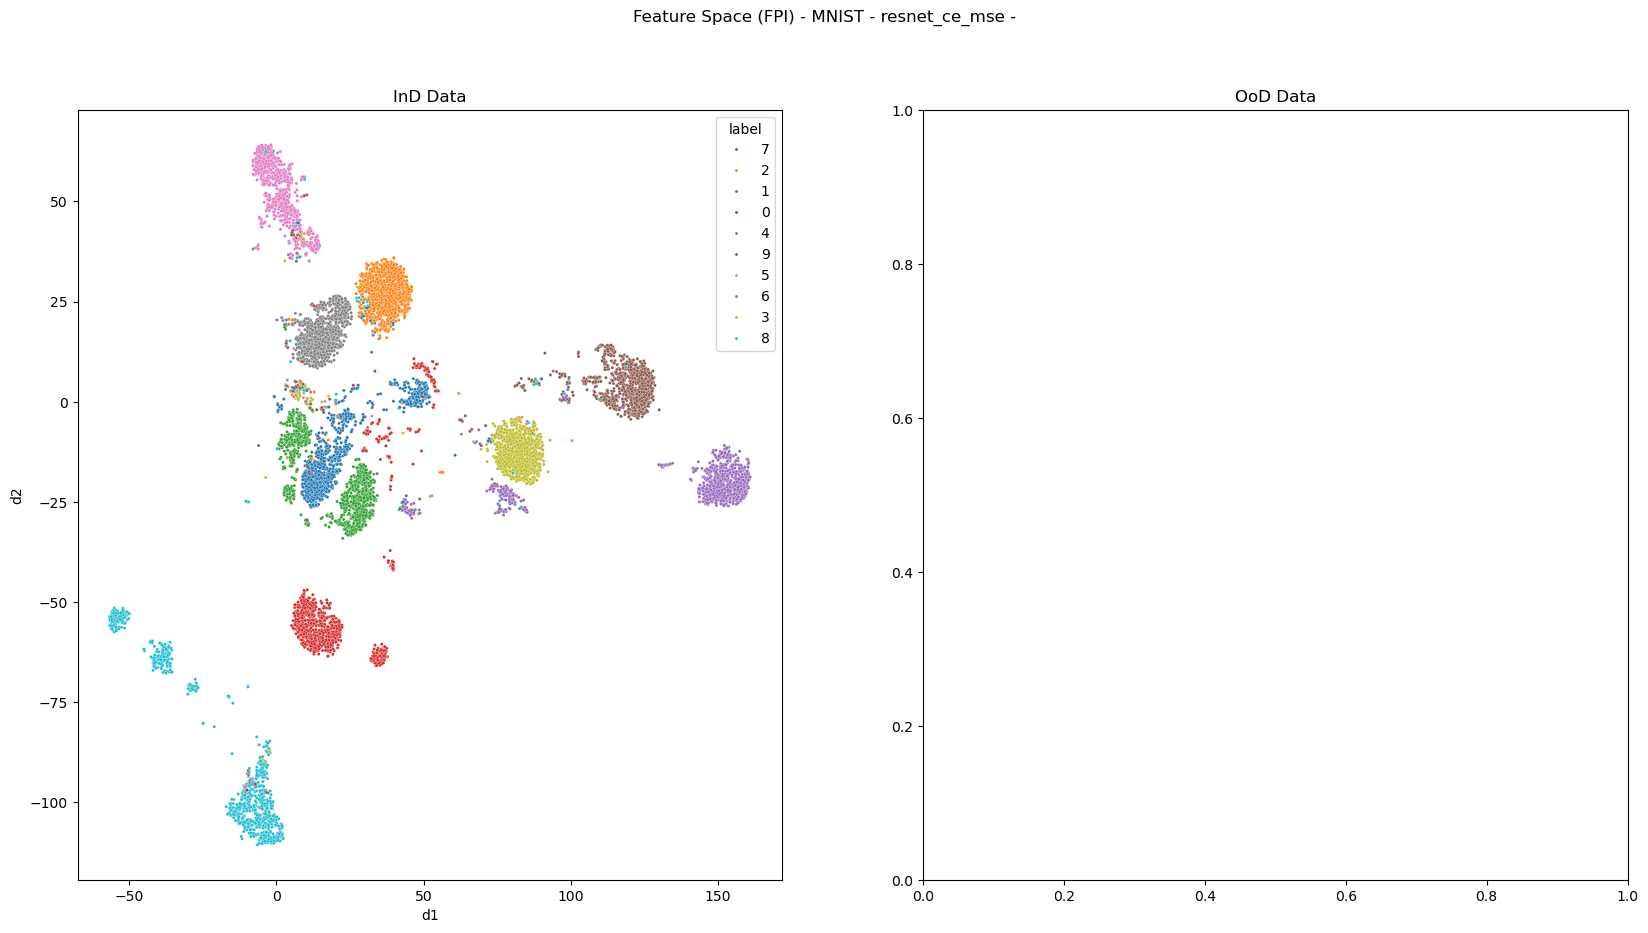

In [12]:
# plot feature space
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

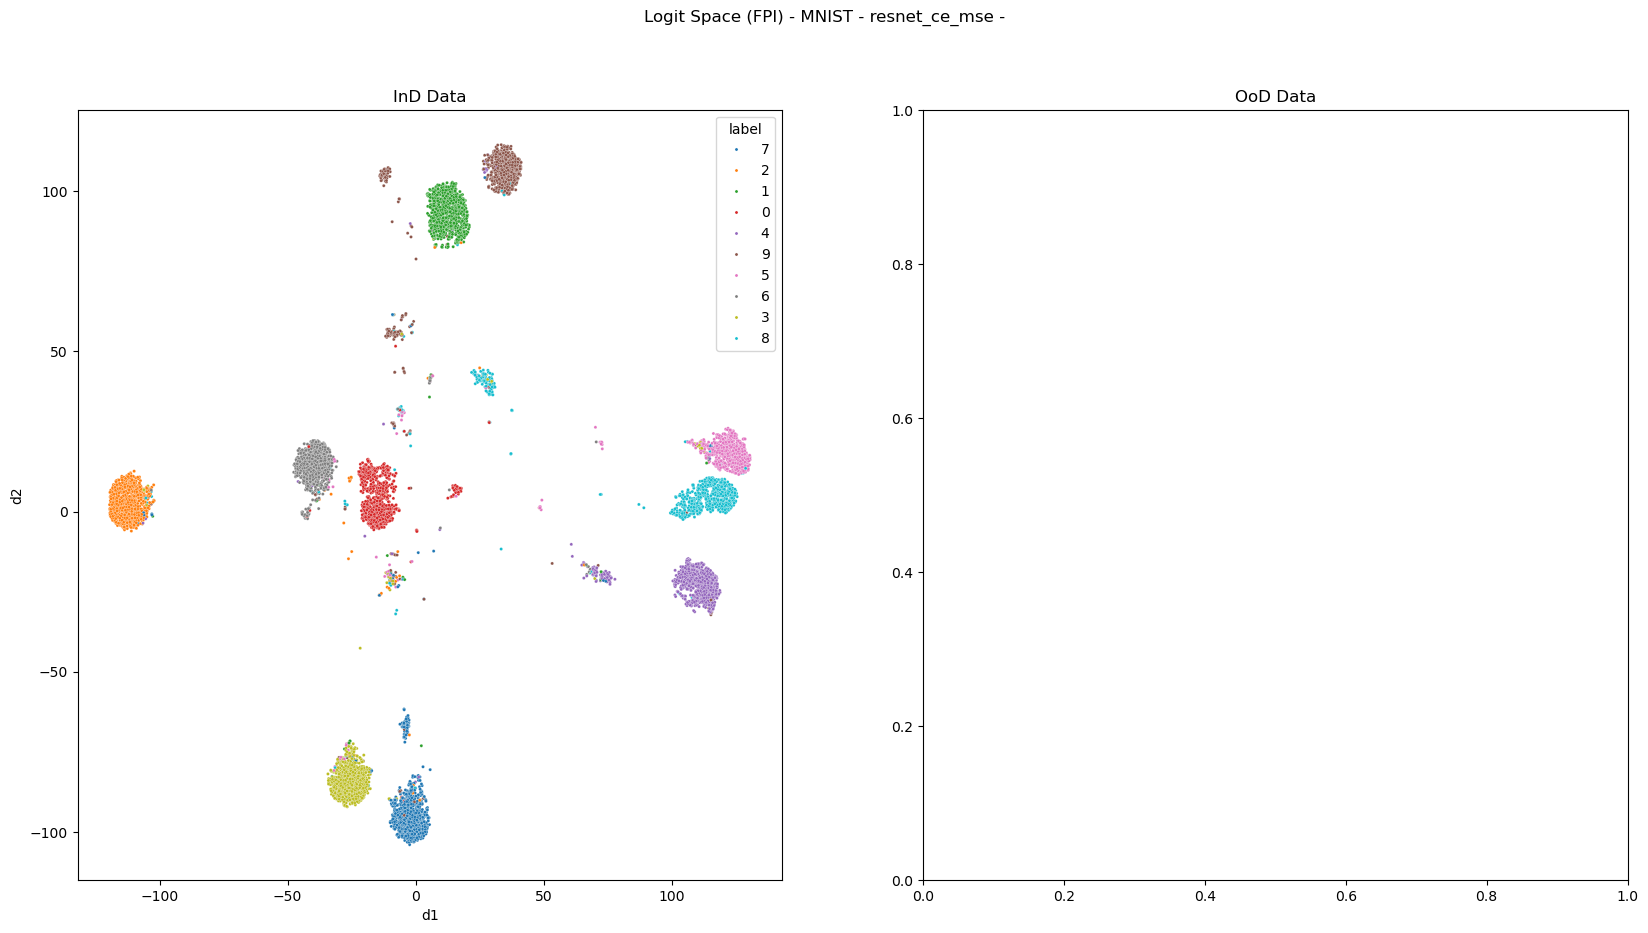

In [13]:
# plot logit space
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:01,  1.93it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:01<00:01,  1.92it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:01<00:00,  1.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]

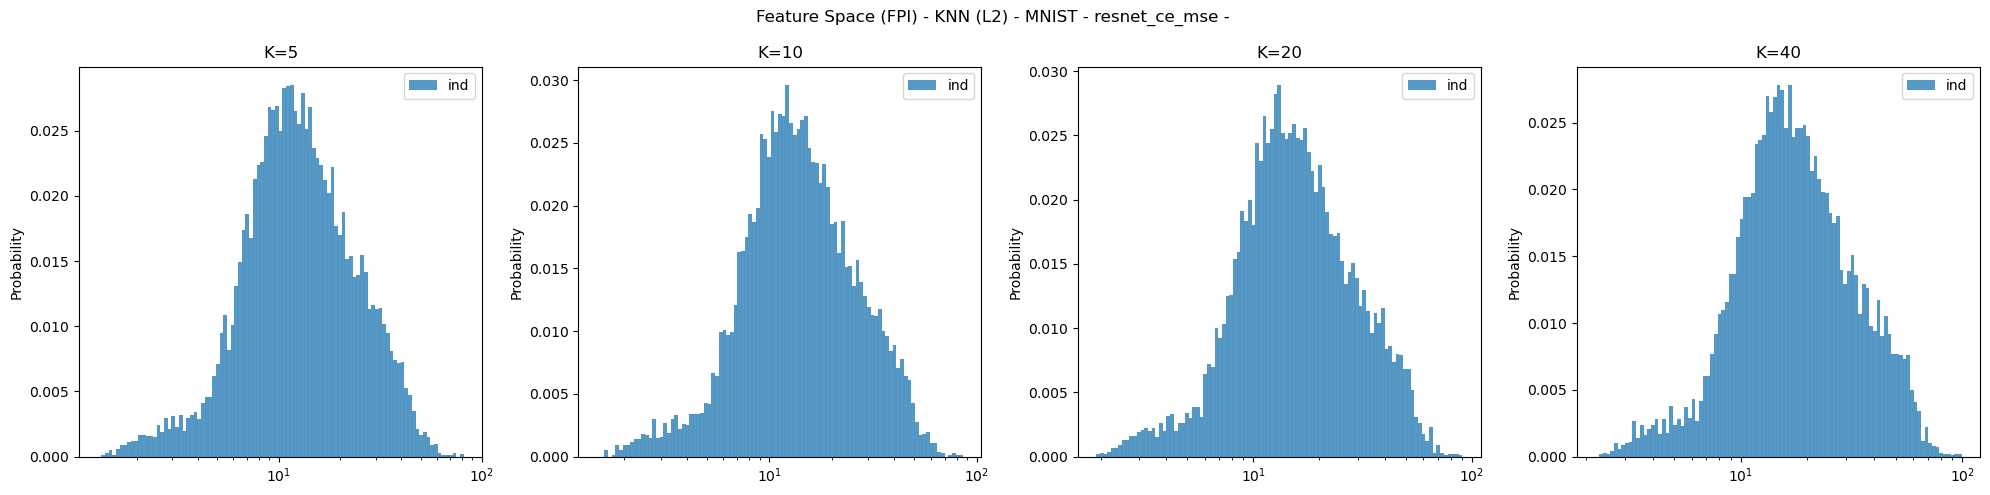

In [14]:
# plot knn to val data in feature space (L2)
index = faiss.IndexFlatL2(ind_emb_fpi.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:01,  2.02it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:01<00:01,  1.99it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:01<00:00,  1.95it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]

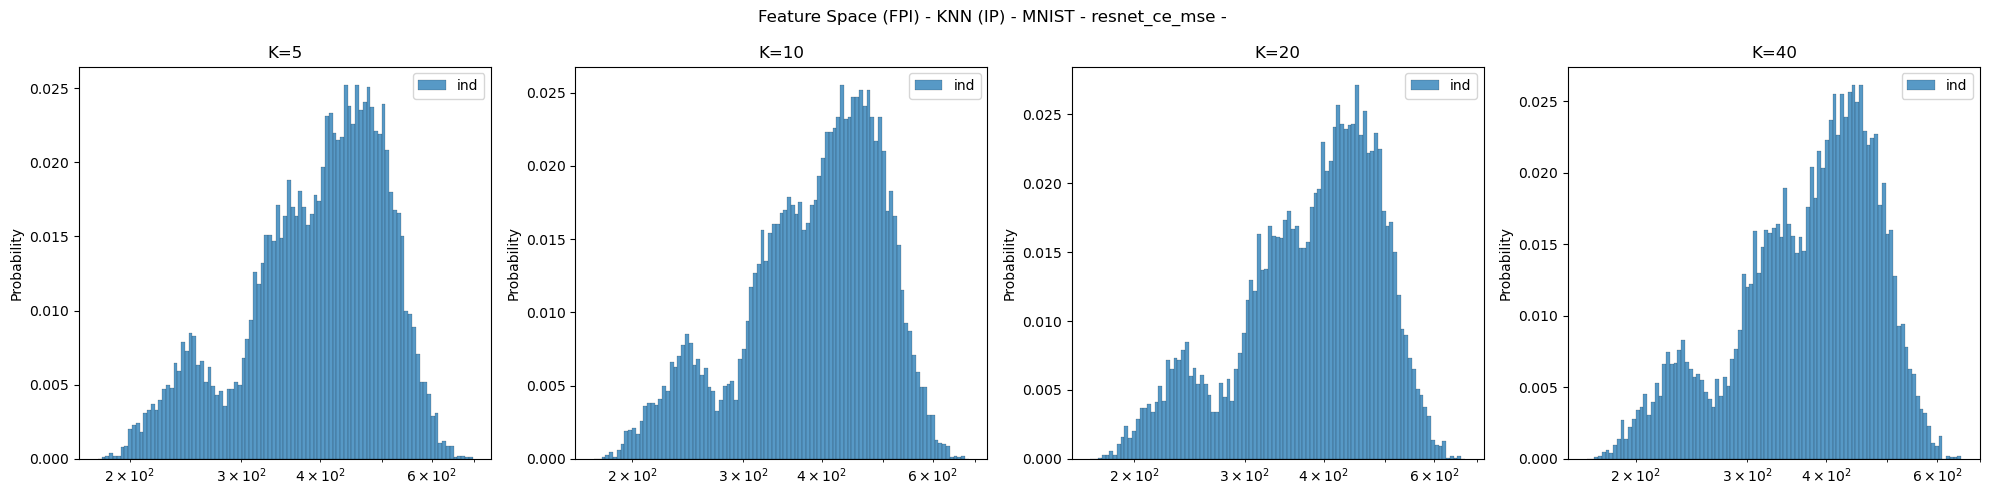

In [15]:
# check knn to val data in feature space (IP)
index = faiss.IndexFlatIP(ind_emb_fpi.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:01,  1.95it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:01<00:01,  1.92it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:01<00:00,  1.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]

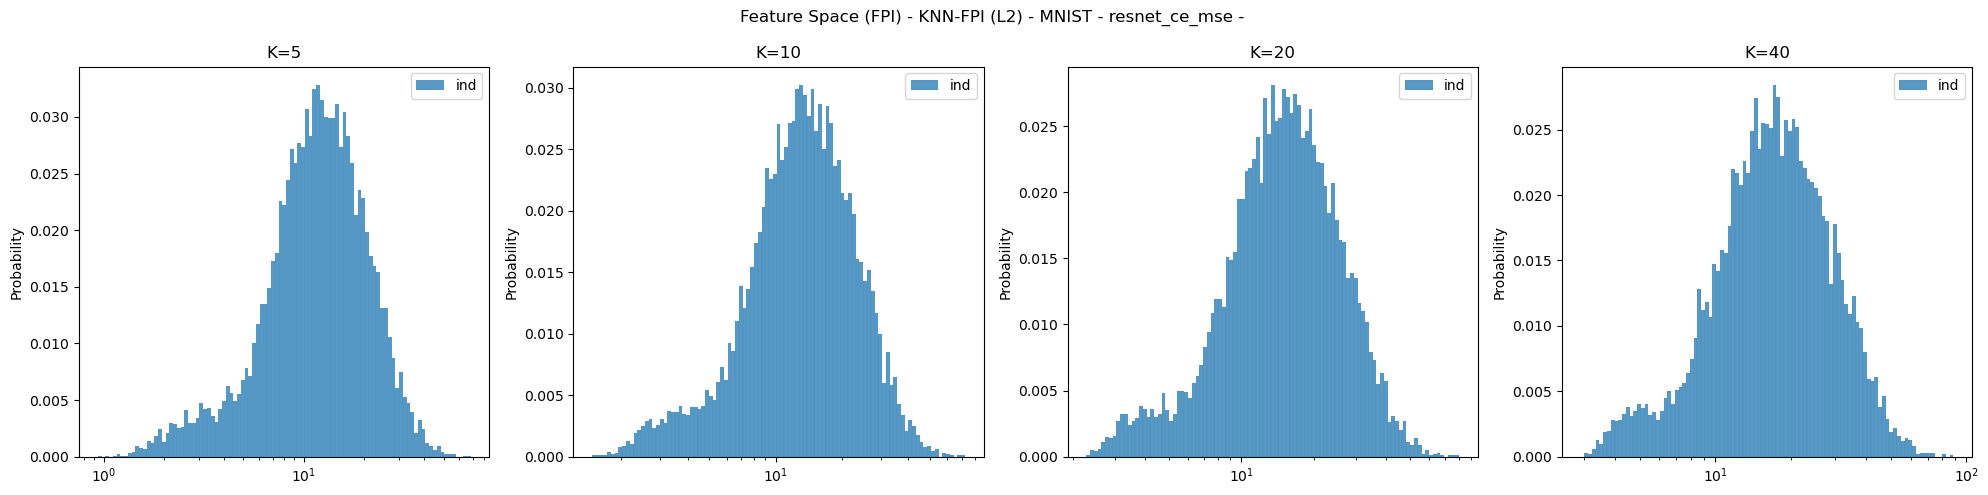

In [16]:
# check knn to val data FPI in feature space (L2)
index = faiss.IndexFlatL2(ind_emb_fpi.shape[-1])
index.add(val_emb_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN-FPI (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:01,  2.03it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:00<00:00,  2.01it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:01<00:00,  1.95it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]

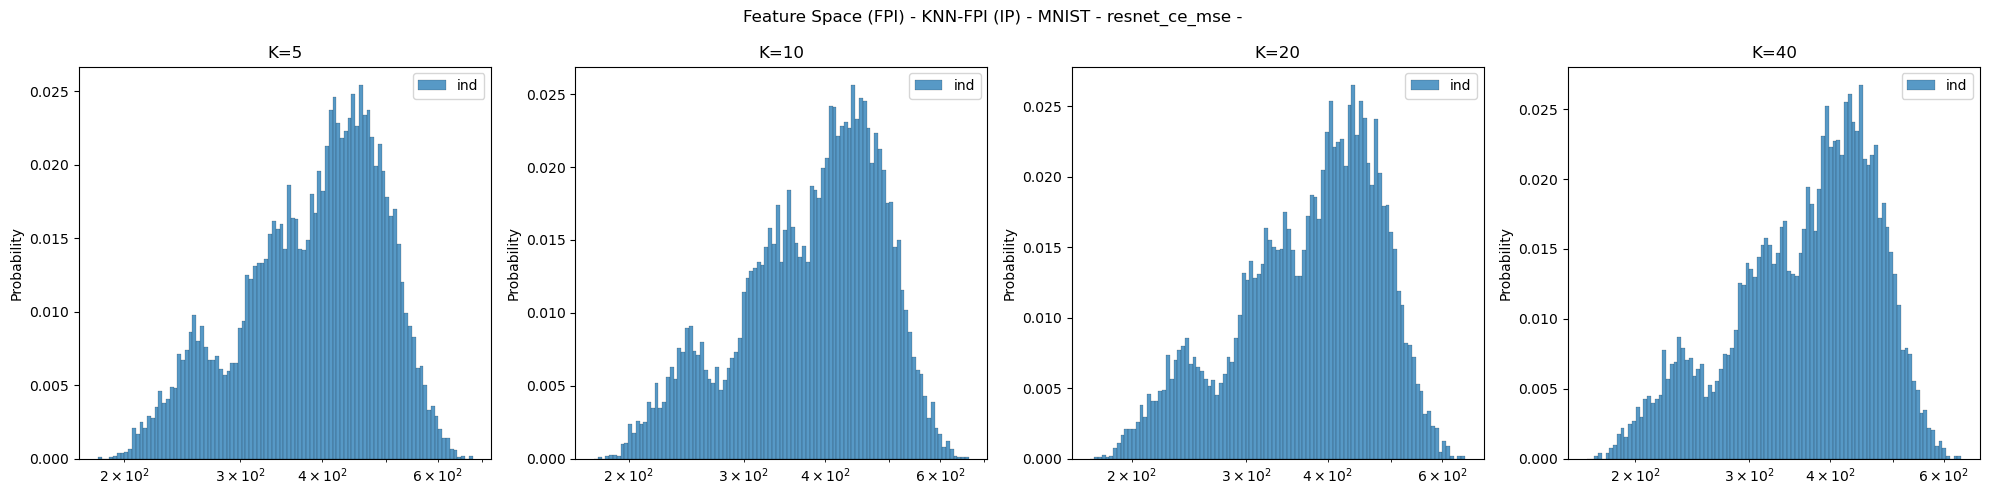

In [17]:
# check knn to val data FPI in feature space (IP)
index = faiss.IndexFlatIP(ind_emb_fpi.shape[-1])
index.add(val_emb_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN-FPI (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:00,  5.56it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:00<00:00,  5.37it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:00<00:00,  5.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.42it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.69it/s]

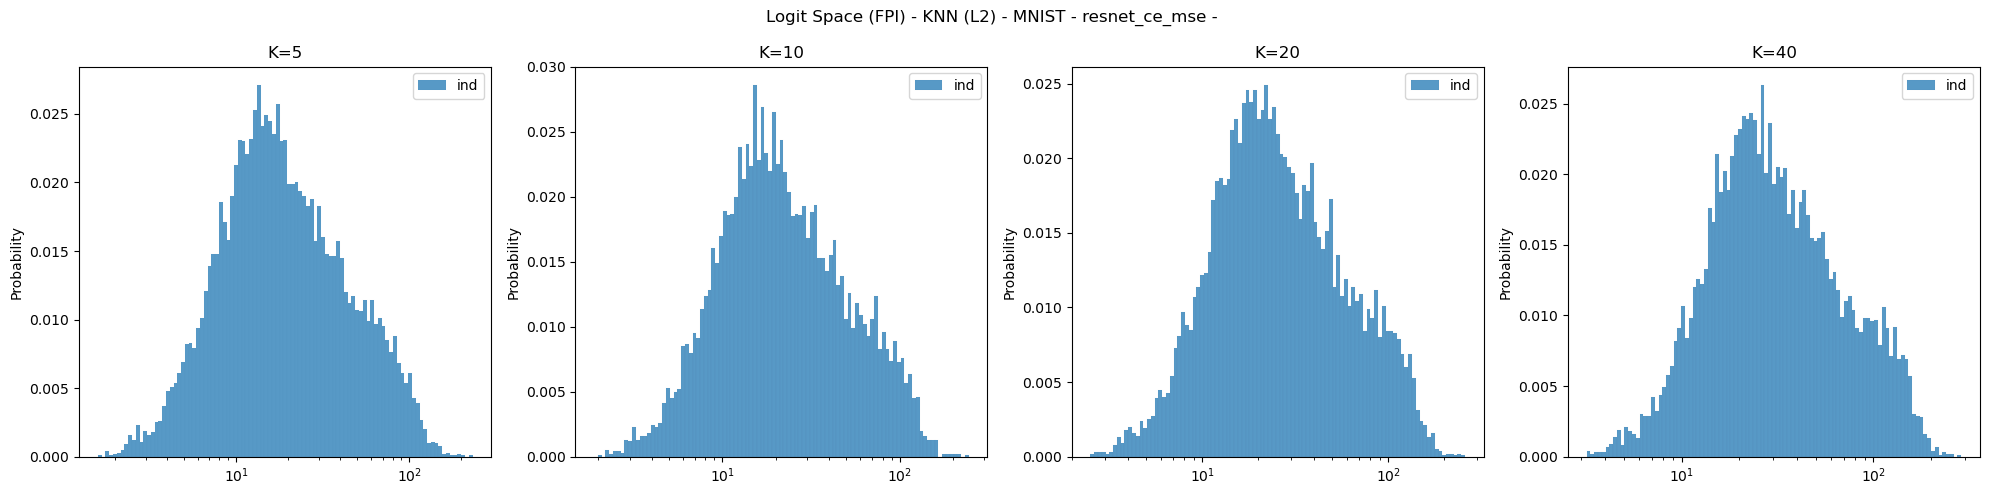

In [18]:
# check knn to val data in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt_fpi.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:00,  6.05it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:00<00:00,  5.85it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:00<00:00,  5.40it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.71it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.02it/s]

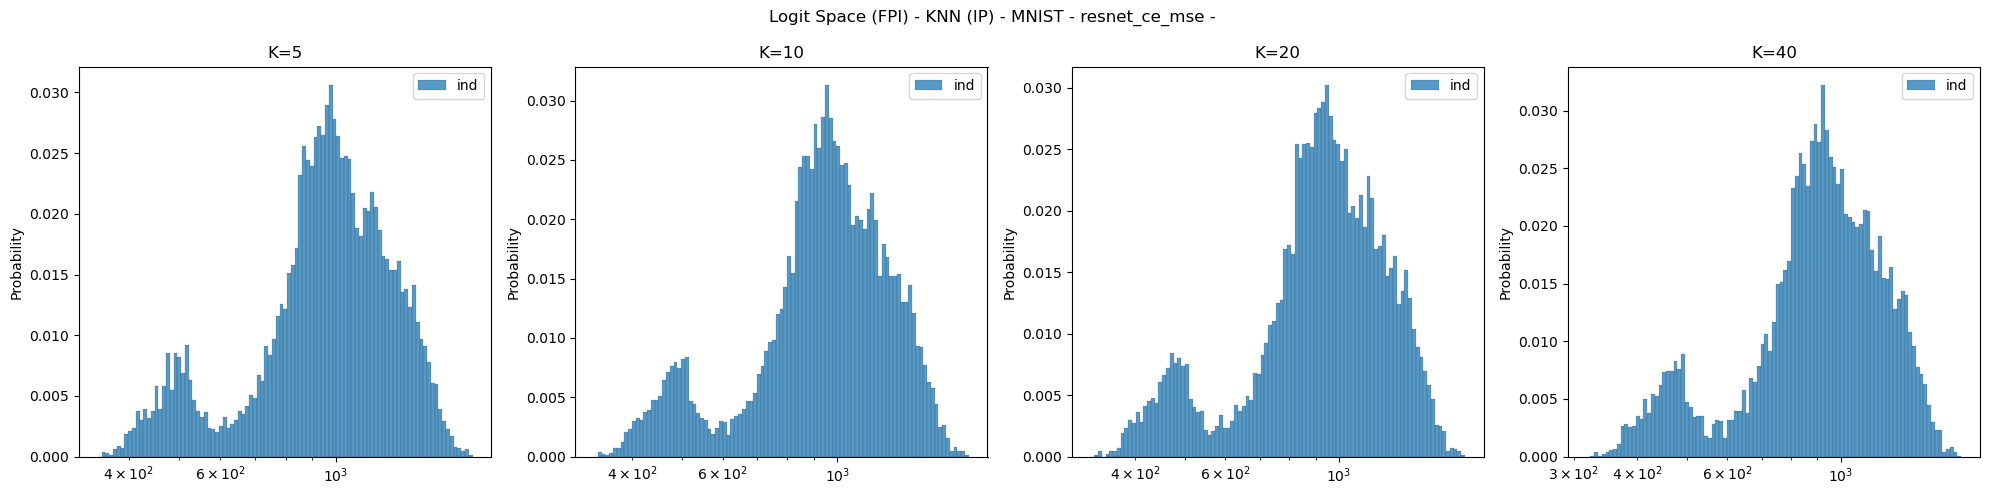

In [19]:
# check knn to val data in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt_fpi.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:00,  5.58it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:00<00:00,  5.38it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:00<00:00,  5.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.39it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.67it/s]

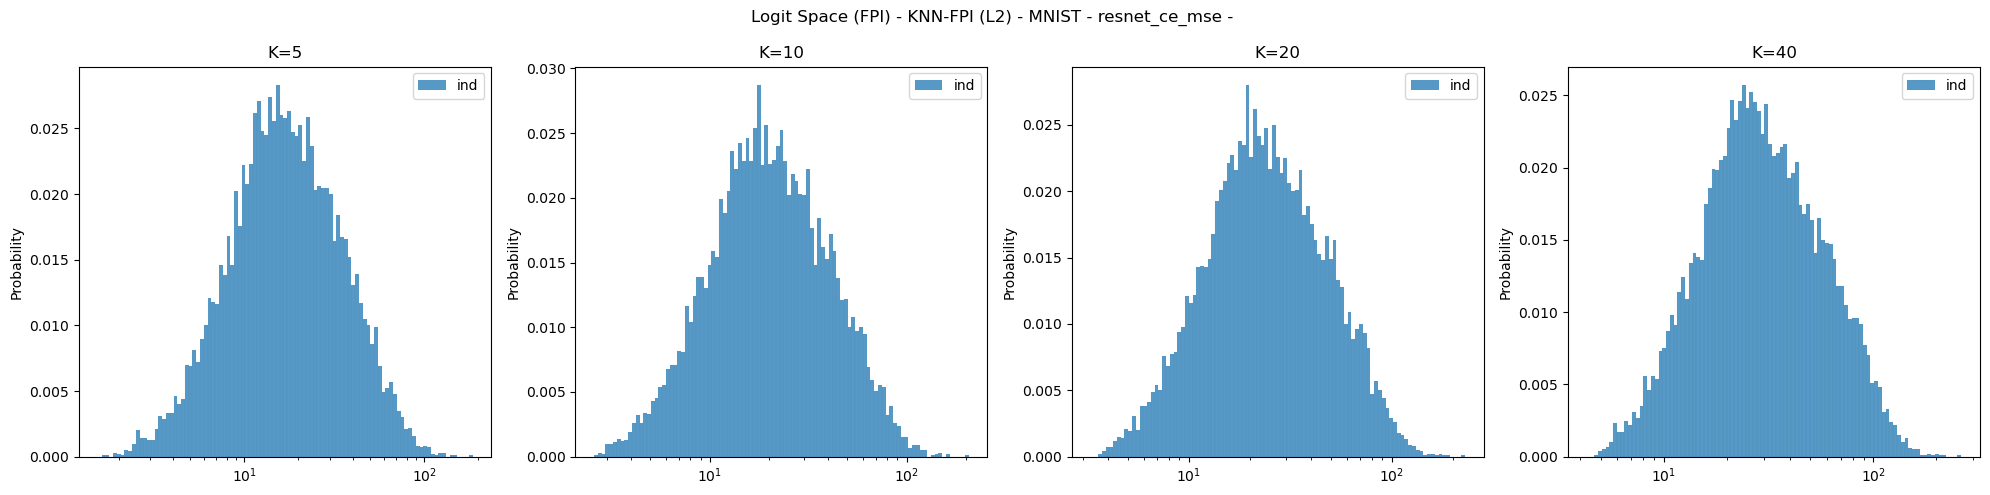

In [20]:
# check knn to val data FPI in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt_fpi.shape[-1])
index.add(val_lgt_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN-FPI (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:00,  6.07it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:00<00:00,  3.19it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:00<00:00,  3.80it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.83it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.83it/s]

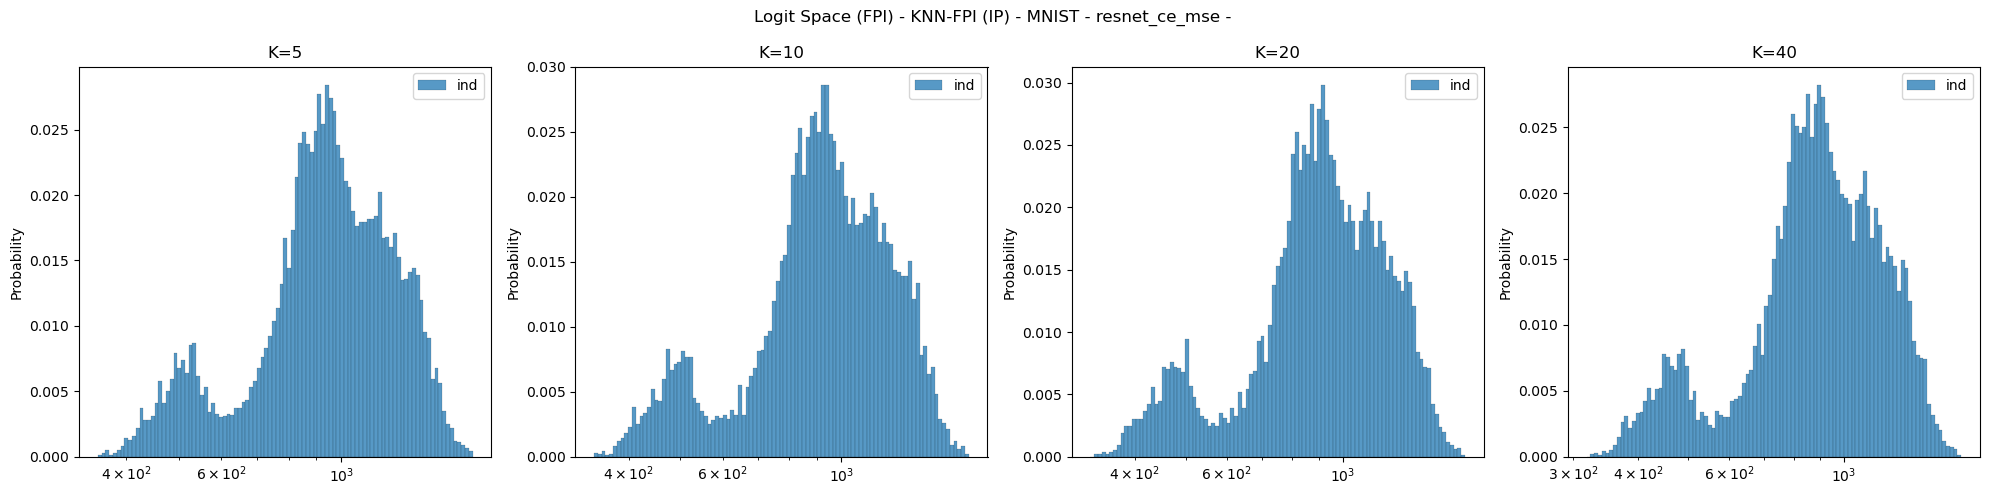

In [21]:
# check knn to val data FPI in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt_fpi.shape[-1])
index.add(val_lgt_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN-FPI (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

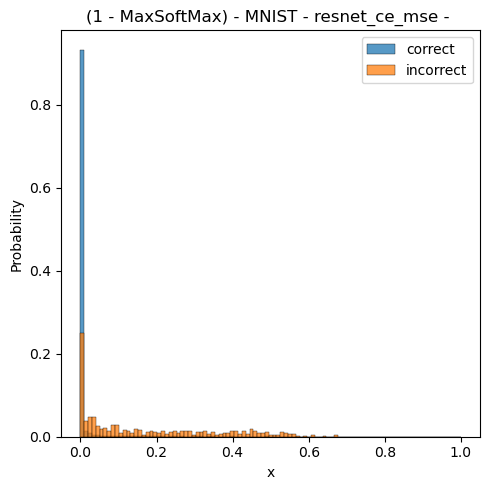

In [22]:
# plot (1 - maxsoftmax) distribution
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

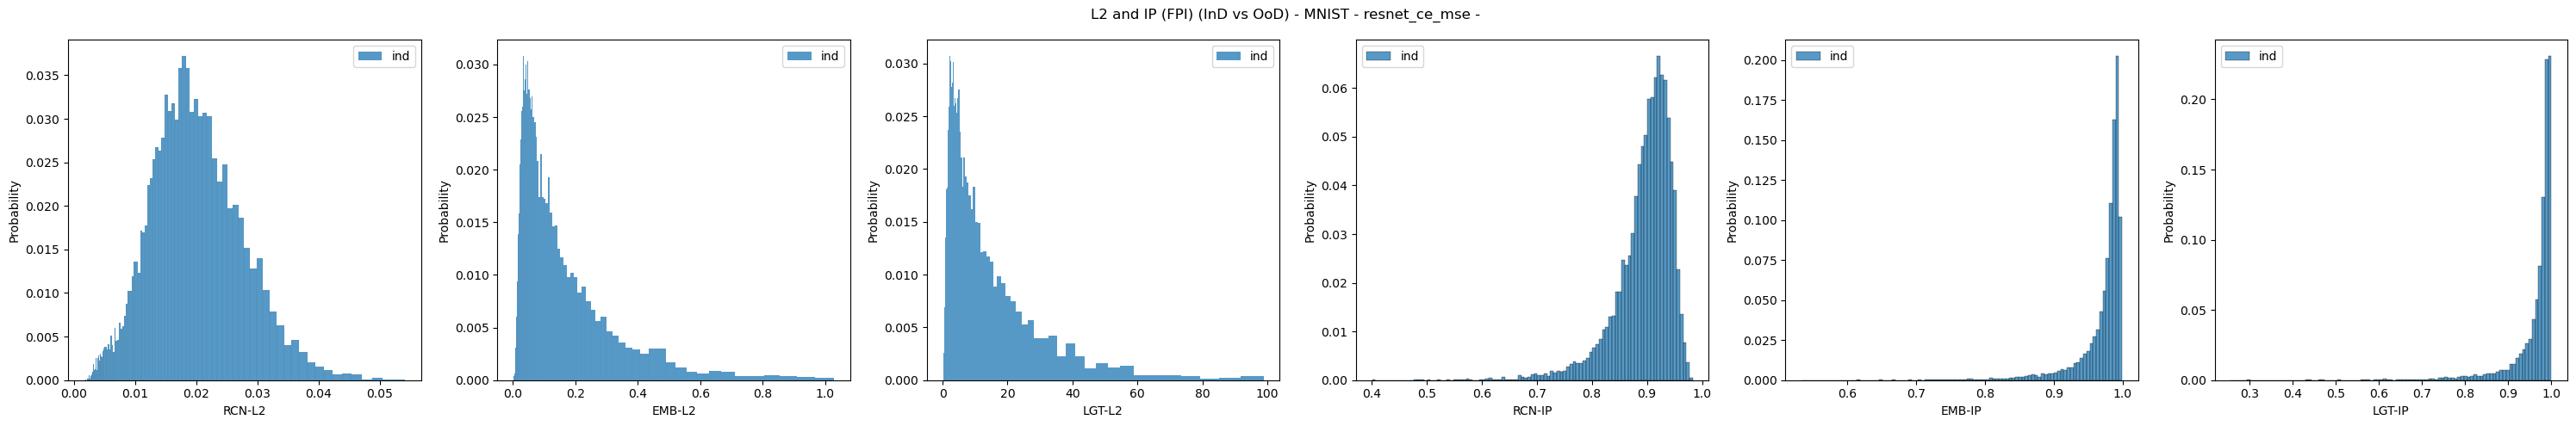

In [23]:
# plot fpi-reconstruction-based ood metrics
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
# data
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_emb = ind_emb.reshape(si)
_ind_lgt = ind_lgt.reshape(si)
_ind_rcn_fpi = ind_rcn_fpi.reshape(si)
_ind_emb_fpi = ind_emb_fpi.reshape(si)
_ind_lgt_fpi = ind_lgt_fpi.reshape(si)
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
_ind_emb_unit = _ind_emb / (np.linalg.norm(_ind_emb, axis=-1, keepdims=True) + 1e-7)
_ind_lgt_unit = _ind_lgt / (np.linalg.norm(_ind_lgt, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_fpi_unit = _ind_rcn_fpi / (np.linalg.norm(_ind_rcn_fpi, axis=-1, keepdims=True) + 1e-7)
_ind_emb_fpi_unit = _ind_emb_fpi / (np.linalg.norm(_ind_emb_fpi, axis=-1, keepdims=True) + 1e-7)
_ind_lgt_fpi_unit = _ind_lgt_fpi / (np.linalg.norm(_ind_lgt_fpi, axis=-1, keepdims=True) + 1e-7)
# mse
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
# ip
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)
# store
_df = pd.DataFrame(dict(
    target=ind_tgt,
    rcn_l2=ind_rcn_l2_fpi,
    emb_l2=ind_emb_l2_fpi,
    lgt_l2=ind_lgt_l2_fpi,
    rcn_ip=ind_rcn_ip_fpi,
    emb_ip=ind_emb_ip_fpi,
    lgt_ip=ind_lgt_ip_fpi,
    source="ind",
))
df_rstat = pd.concat([df_rstat, _df], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    # data
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_emb = ood_emb.reshape(so)
    _ood_lgt = ood_lgt.reshape(so)
    _ood_rcn_fpi = ood_rcn_fpi.reshape(so)
    _ood_emb_fpi = ood_emb_fpi.reshape(so)
    _ood_lgt_fpi = ood_lgt_fpi.reshape(so)
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    _ood_emb_unit = _ood_emb / (np.linalg.norm(_ood_emb, axis=-1, keepdims=True) + 1e-7)
    _ood_lgt_unit = _ood_lgt / (np.linalg.norm(_ood_lgt, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_fpi_unit = _ood_rcn_fpi / (np.linalg.norm(_ood_rcn_fpi, axis=-1, keepdims=True) + 1e-7)
    _ood_emb_fpi_unit = _ood_emb_fpi / (np.linalg.norm(_ood_emb_fpi, axis=-1, keepdims=True) + 1e-7)
    _ood_lgt_fpi_unit = _ood_lgt_fpi / (np.linalg.norm(_ood_lgt_fpi, axis=-1, keepdims=True) + 1e-7)
    # mse
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    # ip
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)
    # store
    _df = pd.DataFrame(dict(
        target=ood_tgt,
        rcn_l2=ood_rcn_l2_fpi,
        emb_l2=ood_emb_l2_fpi,
        lgt_l2=ood_lgt_l2_fpi,
        rcn_ip=ood_rcn_ip_fpi,
        emb_ip=ood_emb_ip_fpi,
        lgt_ip=ood_lgt_ip_fpi,
        source="ood",
    ))
    df_rstat = pd.concat([df_rstat, _df], ignore_index=True)
    
bins_rcn_l2 = np.logspace(np.log10(df_rstat['rcn_l2'].min() + 1e-7), np.log10(df_rstat['rcn_l2'].max()), 100)
bins_emb_l2 = np.logspace(np.log10(df_rstat['emb_l2'].min() + 1e-7), np.log10(df_rstat['emb_l2'].max()), 100)
bins_lgt_l2 = np.logspace(np.log10(df_rstat['lgt_l2'].min() + 1e-7), np.log10(df_rstat['lgt_l2'].max()), 100)
bins_rcn_ip = np.linspace(df_rstat['rcn_ip'].min(), df_rstat['rcn_ip'].max(), 100)
bins_emb_ip = np.linspace(df_rstat['emb_ip'].min(), df_rstat['emb_ip'].max(), 100)
bins_lgt_ip = np.linspace(df_rstat['lgt_ip'].min(), df_rstat['lgt_ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="emb_l2", label="ind", stat="probability", bins=bins_emb_l2, ax=ax2)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="lgt_l2", label="ind", stat="probability", bins=bins_lgt_l2, ax=ax3)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax4)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="emb_ip", label="ind", stat="probability", bins=bins_emb_ip, ax=ax5)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="lgt_ip", label="ind", stat="probability", bins=bins_lgt_ip, ax=ax6)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="emb_l2", label="ind", stat="probability", bins=bins_emb_l2, ax=ax2)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="lgt_l2", label="ind", stat="probability", bins=bins_lgt_l2, ax=ax3)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax4)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="emb_ip", label="ind", stat="probability", bins=bins_emb_ip, ax=ax5)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="lgt_ip", label="ind", stat="probability", bins=bins_lgt_ip, ax=ax6)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
ax1.set_xlabel("RCN-L2")
ax2.set_xlabel("EMB-L2")
ax3.set_xlabel("LGT-L2")
ax4.set_xlabel("RCN-IP")
ax5.set_xlabel("EMB-IP")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()